In [47]:
import numpy as np
import lbg_forecast.sfh as sfh
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [ ]:
#run='test_sfr_em'
#i=0
#sps_params = np.load("sps_parameter_samples/sps_"+run+".npy", allow_pickle=True)[0]

#redshift = sps_params[:, 0]
#dust1 = sps_params[:, 2]
#dust2 = sps_params[:, 3]
#dust_index = sps_params[:, 4]
#mass = sps_params[:, -1]
#logsfrratios = sps_params[:, 10:-1]

#sfr_test = np.log10(sfh.calculate_recent_sfr(redshift, mass, logsfrratios))
#sps_test = np.hstack((np.expand_dims(redshift, axis=1), logsfrratios, np.expand_dims(np.log10(mass), axis=1)))

#x = np.save("sfr_emulator/train_x_mean.npy", sps_test)
#y = np.save("sfr_emulator/train_y_mean.npy", sfr_test)

#x_test, y_test = process_training_data(sps_test, sfr_test)

#y_pred = model(x_test)

In [2]:
def process_training_data(x, y):
    x_train, y_train = tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(np.expand_dims(y, axis=1), dtype=tf.float32)
    x_train_shift = tf.math.reduce_mean(x_train)
    x_train_scale = tf.math.reduce_std(x_train)
    x_train = (x_train - x_train_shift)/x_train_scale
    return x_train, y_train

In [49]:
nsamples=4000000
x = np.load("sfr_emulator/train_x_mean.npy")[:nsamples]
y = np.load("sfr_emulator/train_y_mean.npy")[:nsamples]

In [50]:
x, x_test, y, y_test = train_test_split(x, y, test_size=0.25, random_state=None, shuffle=True)

x_train, y_train = process_training_data(x, y)
x_test, y_test = process_training_data(x_test, y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(TensorShape([3000000, 8]),
 TensorShape([3000000, 1]),
 TensorShape([1000000, 8]),
 TensorShape([1000000, 1]))

In [51]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation='relu', input_shape=(8,)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1),
])

loss_fn = tf.keras.losses.MeanAbsoluteError(reduction='sum_over_batch_size', name='mean_squared_error')

def loss(model, x, y):
    y_pred = model(x)
    return loss_fn(y_true=y, y_pred=y_pred)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)


In [52]:
lrs=[1e-3, 1e-4, 1e-4]
batches=[1000, 5000, 10000]

running_loss = []

for lr, batch in zip(lrs, batches):
    print("learning rate: ", lr)
    print("batch: ", batch)
    optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
     
    training_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(x_train.shape[0]).batch(batch)

    for sps, sfr in training_data:
        loss_value, grads = grad(model, sps, sfr)
        optimiser.apply_gradients(zip(grads, model.trainable_variables))
        running_loss.append(loss_value)


learning rate:  0.001
batch:  1000
learning rate:  0.0001
batch:  5000
learning rate:  0.0001
batch:  10000


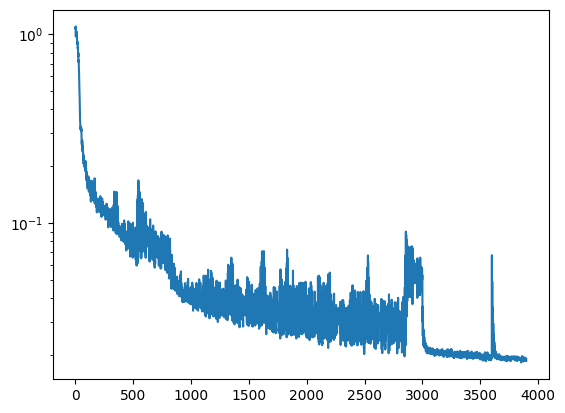

In [53]:
plt.plot(running_loss)
plt.yscale('log')

In [54]:
loss(model, x_train, y_train).numpy()

5.37301e-05

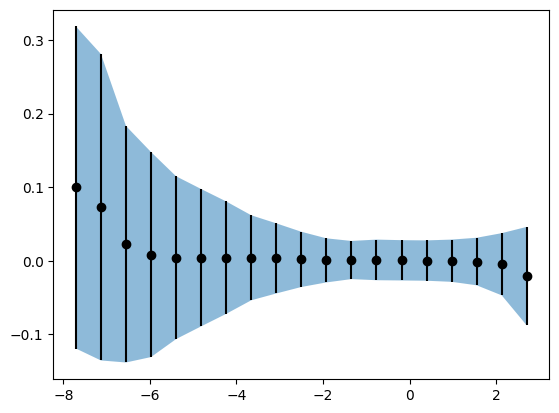

In [55]:
import scipy as sc
def process_samples(x, y, xl, xh, ngrid=15):

    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, y, 'mean', np.linspace(xl, xh, ngrid))
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, y, 'std', np.linspace(xl, xh, ngrid))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    return bin_centers, bin_means, bin_std

y_pred = model(x_test)

error = ((y_pred.numpy()-y_test.numpy())).flatten()#)/y_test)*100
#plt.scatter(x_test[:, 0], percentage_error)

bin_centers, bin_means, bin_std = process_samples(y_test.numpy().flatten(), error, -8, 3, 20)
plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko')
plt.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.5)

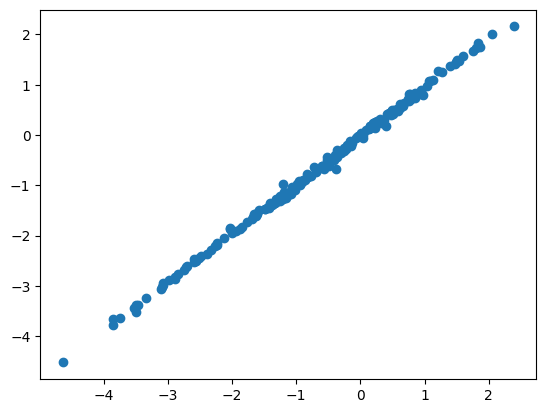

In [56]:
run='test'
i=0
sps_params = np.load("sps_parameter_samples/sps_"+run+".npy", allow_pickle=True)[0]

n=200
redshift = sps_params[:, 0]
dust1 = sps_params[:, 2]
dust2 = sps_params[:, 3]
dust_index = sps_params[:, 4]
mass = sps_params[:, -1]
logsfrratios = sps_params[:, 10:-1]

sfr_test = np.log10(sfh.calculate_recent_sfr(redshift, mass, logsfrratios))
sps_test = np.hstack((np.expand_dims(redshift, axis=1), logsfrratios, np.expand_dims(np.log10(mass), axis=1)))

x_test, y_test = process_training_data(sps_test, sfr_test)

y_pred = model(x_test)

#plt.scatter(sfr_test, dust2)
#plt.scatter(y_pred.numpy(), dust2)
plt.scatter(y_test, y_pred)

#error = ((y_pred.numpy()-y_test.numpy())).flatten()#)/y_test)*100

#bin_centers, bin_means, bin_std = process_samples(y_test.numpy().flatten(), error, -8, 3, 20)
#plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko')
#plt.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.5)

In [11]:
#joblib.dump(regressor, 'sfr_emulator/sfr_emulator_test.pkl')